In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
signal_data = pd.read_parquet('/dice/projects/CMS/Hinv/ml_datasets_ULRun2_250310/ml_inputs_UL2018/ttH_HToInvisible_M125.parquet')

background_data_ttsemilep = pd.read_parquet('/dice/projects/CMS/Hinv/ml_datasets_ULRun2_250310/ml_inputs_UL2018/TTToSemiLeptonic.parquet')
background_data_tthadronic = pd.read_parquet('/dice/projects/CMS/Hinv/ml_datasets_ULRun2_250310/ml_inputs_UL2018/TTToHadronic.parquet')
background_data_ttdilep = pd.read_parquet('/dice/projects/CMS/Hinv/ml_datasets_ULRun2_250310/ml_inputs_UL2018/TTTo2L2Nu.parquet')


background_data = pd.concat([background_data_ttsemilep, background_data_tthadronic, background_data_ttdilep])


In [3]:
## DATA PREPARATION



def prep(signal_data, background_data):

    #remove NaN values
    signal_data = signal_data.dropna()
    background_data = background_data.dropna()

    #remove unsuitable regions in the regions column (want only 0 and 6+)
    regions_to_exclude = [1,2,3,4,5]
    signal_data = signal_data[~signal_data.region.isin(regions_to_exclude)]
    background_data = background_data[~background_data.region.isin(regions_to_exclude)]
    
    #add balance weights
    # this helps balance the training dataset. Signal data points are given HIGHER weights based on the imbalance
    #weight=1 is the base weight, which we assign to background_data
    # creating new column 'weight_balance' and assigning it to 1 for background_data and len(background_data)/len(signal_data) for signal_data
    signal_data['weight_balance'] = len(background_data) / len(signal_data)
    background_data['weight_balance'] = 1
    #this weight is applied to the loss^ 

    # Label signal and background data
    signal_data['target'] = 1
    background_data['target'] = 0

    #combine sign & BG datasets
    data = pd.concat([signal_data, background_data])



    ###
    # Look into jets, otherwise just delete:

    #add additional columns to the data frame
    # calculating statistical properties of cleanedJet_eta and 
    #cleanedJet_phi, such as standard deviation (std) and range (max-min).
    #New features can be useful for model
    # data['cleanedJet_eta_std'] = data['cleanedJet_eta'].apply(lambda x: np.std(x))
    # data['cleanedJet_eta_range'] = data['cleanedJet_eta'].apply(lambda x: np.max(x) - np.min(x))
    # data['cleanedJet_phi_std'] = data['cleanedJet_phi'].apply(lambda x: np.std(x))
    # data['cleanedJet_phi_range'] = data['cleanedJet_phi'].apply(lambda x: np.max(x) - np.min(x))
    # ###
    return data

data = prep(signal_data, background_data)


In [4]:
# Define features and scale them
features = [
    'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi', 'InputMet_pt', 'MHT_pt',
    'MinChi', 'MinOmegaHat', 'MinOmegaTilde','ldphi_bjet', 'ldphi_jet', 'ncleanedBJet',
    'ncleanedJet', 'region', 'sdphi_bjet', 'sdphi_jet'
]

#scales features to have a mean = 0  and std = 1 (makes training more stable & efficient).
scaler = StandardScaler()
#Fit the scalar to selected features in data & transform them in place, overwriting opriginal values witht he SCALED ones
data[features] = scaler.fit_transform(data[features])



#we need to scale as some features varyb widely in magnitude which can hinder training.
#NN's are sensitive to the scale of the input data. Scaling ensures all features contribute proportionally to the models training process.


In [5]:
len(features)

15

In [6]:
# Convert data to PyTorch tensors

#Convert features to tensors(x). X is a tensor containing values of selected features from data[features].values
X = torch.tensor(data[features].values, dtype=torch.float32)

# Convert target to tensors(y). y is a tensor of target labels, indicating whether sample is sig (1) or BG (0).as_integer_ratio
# #.view(-1,1) reshapes y into column vector for binary classification.
y = torch.tensor(data['target'].values, dtype=torch.float32).view(-1, 1)

#converting weights to tensors. Used later in training loop to handle class imbalance
weights_nominal = torch.tensor(data['weight_nominal'].values, dtype=torch.float32)
weights_balance = torch.tensor(data['weight_balance'].values, dtype=torch.float32)


In [7]:
# Split data into train, validation, and test sets.
#80/20 train/test split. Outputs represent features labels, nominal weights & balance weights for both..
#.. training & validation set and test set.
X_train_val, X_test, y_train_val, y_test, wn_train_val, wn_test, wb_train_val, wb_test = train_test_split(
    X, y, weights_nominal, weights_balance, test_size=0.2, random_state=42
)
#each x_train val is paired with y_train_val, wn_train_val, wb_train_val. (X_train_val, y_train_val, wn_train_val, wb_train_val)
#each x_test is paired with y_test, wn_test, wb_test. (X_test, y_test, wn_test, wb_test)
# ... allows us to keep track of weights. 

#this splits the training+validation set into   (64%) and validation (16%). These numbers come from 0.8*0.8=0.64, 0.8*0.2=0.16. 
#1st split is training+validation vs test. Second split only on the training+validation. 80% training, 20% validation.
X_train, X_val, y_train, y_val, wn_train, wn_val, wb_train, wb_val = train_test_split(
    X_train_val, y_train_val, wn_train_val, wb_train_val, test_size=0.2, random_state=42
)


#Training set trains model. (Xtrain,yt_train,wn_train,wb_train)
#Validation set evaluates models performance during trainign & adjusts hyperparameters if needed. (X_val,y_val,wn_val,wb_val
#Test set is set aside until end of training to evaluate the model's generalisation ability on completely unseen data. (xtets,ytest,wntest,wbtest)


In [8]:
# Create DataLoaders

#(#Look at gradient descent mini batch)

#DataLoader is a PyTorch class that loads data in batches.
#train_loader loads training data in batches of 64 samples. shuffle=True shuffles the data before each epoch.
train_loader = DataLoader(TensorDataset(X_train, y_train, wn_train, wb_train), batch_size=64, shuffle=True)

#val_loader loads validation data in batches of 64 samples. shuffle=False as we don't want to shuffle validation data.
val_loader = DataLoader(TensorDataset(X_val, y_val, wn_val, wb_val), batch_size=64, shuffle=False)

#test_loader loads test data in batches of 64 samples. shuffle=False as we don't want to shuffle test data.
test_loader = DataLoader(TensorDataset(X_test, y_test, wn_test, wb_test), batch_size=64, shuffle=False)

#shuffle is set to True for training data, as we want to shuffle the data before each epoch to prevent the model from learning the order of the data.

In [9]:
#Defining NN model & initialising loss function & optimiser

#nn.Module is a base class for all NN models in PyTorch. Represents a simple feedforward..
#.. NN with customisable layers & neurons, disigned for binary classification.

class SimpleNN(nn.Module):
    # n_layers is the no. of HIDDEN LAYERS and n_neurons is the no. of neurons in each HIDDEN layer.
    def __init__(self, n_layers=3, n_neurons=32):
        #super() is a method that returns a proxy object that delegates method calls to a parent or sibling class of type.
        #Here, super(SimpleNN, self).__init__() initialises the base class (nn.Module) for the SimpleNN class.
        super(SimpleNN, self).__init__()
        #layers ia a listy that temporatily holds each layer of the model as it is created.
        #this allows us to construct the NN architecture in a loop, rather than writing each layer out individually.
        layers = [nn.Linear(len(features), n_neurons), nn.BatchNorm1d(n_neurons)]
        
        #for loop that creates n_layers-1 hidden layers, each with n_neurons neurons.
        for _ in range(n_layers - 1):
            layers += [nn.Linear(n_neurons, n_neurons), nn.BatchNorm1d(n_neurons)]
        #adds the output layer to the model. This is a single neuron, as we are performing binary classification.
        layers.append(nn.Linear(n_neurons, 1))
        #nn.ModuleList(layers) converts the list of layers into a PyTorch ModuleList, which is a container for Module objects.
        self.layers = nn.ModuleList(layers)

    #the forward method defines the forward pass of the NN. It takes an input tensor x and passes it through each layer of the model.
    def forward(self, x):
        for layer in self.layers[:-1]:
            #applies the ReLU activation function to the output of each hidden layer to introduce non-linearity.
            x = torch.relu(layer(x))
        
        #return self.layers[-1](x) applies the output layer to the final hidden layer output, returning the final model output.
        return self.layers[-1](x)
        #x is not a value between 0 and 1, but a value between -inf and inf. This is because the output layer is a single neuron with no activation function.
        #x is a logit
model = SimpleNN()



In [10]:
# Define loss function and optimizer

#criterion is the loss function used to train the model. Here, we use Binary Cross-Entropy Loss with logits.
#optimiser is the optimisation algorithm used to update the model weights during training. Here, we use the Adam optimiser.

criterion = nn.BCEWithLogitsLoss(reduction="none")  # With weight balancing
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#lr is the learning rate of the optimiser. This is a hyperparameter that controls the step size of the optimiser during training.

In [11]:
# An epoch is a single pass through the entire training dataset.
n_epochs = 40
#train_losses and val_losses are lists that store the training and validation losses for each epoch.
train_losses, val_losses = [], []

# Training phase
for epoch in range(n_epochs):
    #model.train() sets the model to training model, which enables features like dropout and batch normalisation.
    model.train()

    #running_train_loss and running_val_loss are variables that store the cumulative loss for each epoch.
    running_train_loss = 0.0

    #train_loader is an iterable object that returns batches of training data.
    for batch_x, batch_y, _, batch_wb in train_loader:
        #Zero the gradients to prevent them from accumulating.
        optimizer.zero_grad()
        #model(batch_x) applies the model to the input batch to generate model outputs.
        outputs = model(batch_x)
        #calulates the loss between the model outputs and the target labels.
        loss = criterion(outputs, batch_y.view(-1, 1))

        # Multiplies the loss by the balancing wwight (1 for BG and ~6 for sig) to handle class imbalance.
        weighted_loss = (loss * batch_wb).mean()
        #Backpropagates the loss through the model to calculate the gradients.
        weighted_loss.backward()
        #Updates the model weights using the gradients and the optimiser.

        #goes back and adjusts the weights of the model to reduce the loss. MAYBE
        optimizer.step()
        #running_train_loss accumulates the weighted loss for each batch.
        running_train_loss += weighted_loss.item() * batch_x.size(0)

    #train_losses appends the average training loss for the epoch.
    train_losses.append(running_train_loss / len(train_loader.dataset))





    # Validation phase (model doesn't see this)
    
    #model.eval() sets the model to evaluation mode, which disables features like dropout and batch normalisation.
    model.eval()
    #running_val_loss is a variable that stores the cumulative validation loss for each epoch.
    running_val_loss = 0.0
    #torch.no-grad disables gradient calculation, which reduces memory usage and speeds up computation.
    with torch.no_grad():
        #val_loader is an iterable object that returns batches of validation data.
        for batch_x, batch_y, _, batch_wb in val_loader:
            #calculates the validation loss for the model.
            val_loss = criterion(model(batch_x), batch_y.view(-1, 1))
            #Help handle class imbalance.
            weighted_val_loss = (val_loss * batch_wb).mean()
            # accumulates the weighted validation loss for each batch.
            running_val_loss += weighted_val_loss.item() * batch_x.size(0)
    #val_losses appends the average validation loss for the epoch.
    val_losses.append(running_val_loss / len(val_loader.dataset))

#Prints the training and validation losses for each epoch.
    print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')


/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1730833640211/work/c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/40], Training Loss: 0.6642, Validation Loss: 0.6284
Epoch [2/40], Training Loss: 0.6248, Validation Loss: 0.6149
Epoch [3/40], Training Loss: 0.6139, Validation Loss: 0.6072
Epoch [4/40], Training Loss: 0.6065, Validation Loss: 0.6025
Epoch [5/40], Training Loss: 0.6016, Validation Loss: 0.5991
Epoch [6/40], Training Loss: 0.5979, Validation Loss: 0.5962
Epoch [7/40], Training Loss: 0.5946, Validation Loss: 0.5944
Epoch [8/40], Training Loss: 0.5922, Validation Loss: 0.5911
Epoch [9/40], Training Loss: 0.5911, Validation Loss: 0.5904
Epoch [10/40], Training Loss: 0.5879, Validation Loss: 0.5899
Epoch [11/40], Training Loss: 0.5856, Validation Loss: 0.5887
Epoch [12/40], Training Loss: 0.5841, Validation Loss: 0.5884
Epoch [13/40], Training Loss: 0.5850, Validation Loss: 0.5864
Epoch [14/40], Training Loss: 0.5834, Validation Loss: 0.5860
Epoch [15/40], Training Loss: 0.5812, Validation Loss: 0.5850
Epoch [16/40], Training Loss: 0.5804, Validation Loss: 0.5847
Epoch [17/40], Tr

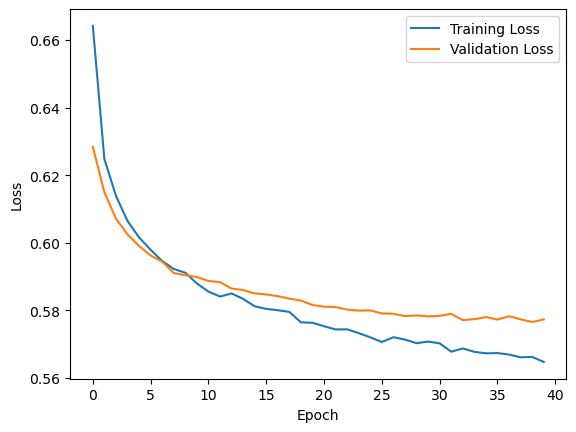

In [12]:
# Plot training and validation losses
plt.plot(range(n_epochs), train_losses, label='Training Loss')
plt.plot(range(n_epochs), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


    

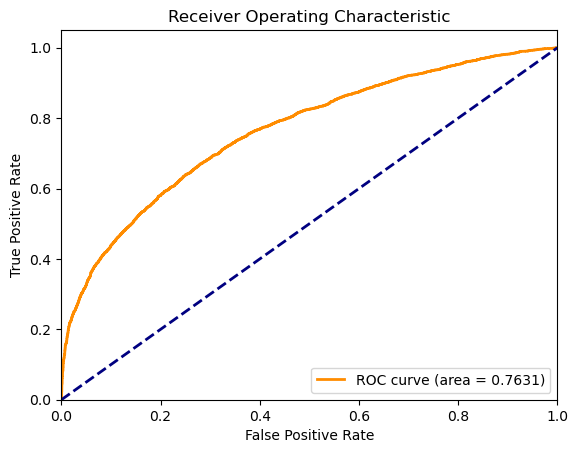

In [13]:
from sklearn.metrics import roc_curve, auc

# Evaluate the model on the test set
model.eval()
y_test_pred = []
with torch.no_grad():
    for batch_x, _, _, _ in test_loader:
        outputs = model(batch_x)
        y_test_pred.append(outputs)

# Concatenate all predictions
y_test_pred = torch.cat(y_test_pred).cpu().numpy()
y_test_true = y_test.cpu().numpy()

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test_true, y_test_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Plot Histograms For Model Output

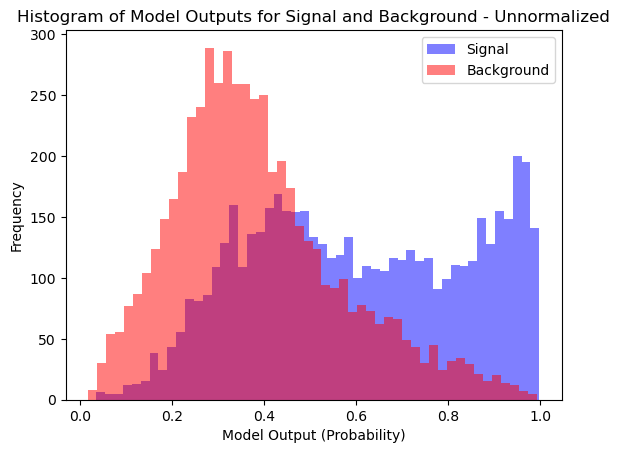

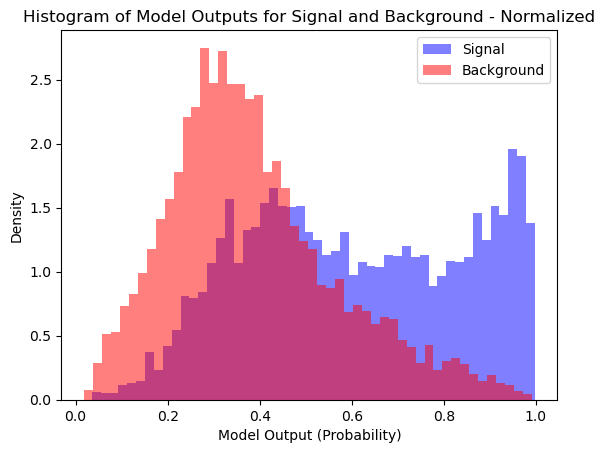

In [14]:
# Apply sigmoid function to model outputs to get probabilities
signal_probs = torch.sigmoid(torch.tensor(y_test_pred[y_test_true == 1])).numpy()
background_probs = torch.sigmoid(torch.tensor(y_test_pred[y_test_true == 0])).numpy()

# Plot histograms
plt.hist(signal_probs, bins=50, alpha=0.5, label='Signal', color='blue')
plt.hist(background_probs, bins=50, alpha=0.5, label='Background', color='red')
plt.xlabel('Model Output (Probability)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of Model Outputs for Signal and Background - Unnormalized')
plt.show()

# Plot normalized histograms
plt.hist(signal_probs, bins=50, alpha=0.5, label='Signal', color='blue', density=True)
plt.hist(background_probs, bins=50, alpha=0.5, label='Background', color='red', density=True)
plt.xlabel('Model Output (Probability)')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.title('Histogram of Model Outputs for Signal and Background - Normalized')
plt.show()

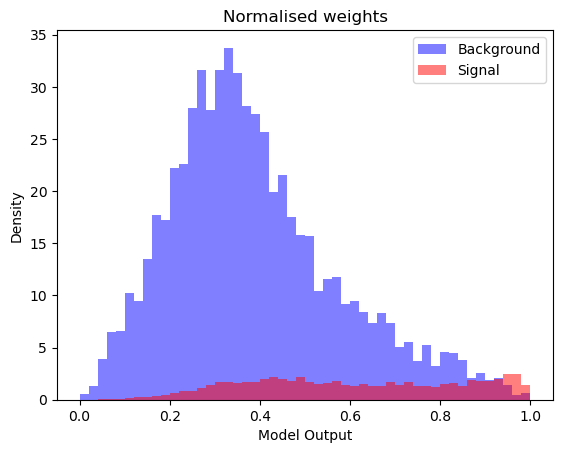

In [15]:
#reread


# Evaluate model on test set with normalised weights
model.eval()

# Lists to store model outputs and labels
all_outputs = []
all_labels = []

# Iterate over test data
with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # outputs = model(batch_x) applies the model to the input batch to generate model outputs.
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        #sigmoid function is applied to the model outputs to convert them to probabilities.
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility

        #all_outputs and all_labels are lists that store the model outputs and target labels for the test set.
        #.extend() appends the model outputs and target labels for each batch to the lists.
        all_outputs.extend(probs)

        #batch_y is the target labels for the batch. .numpy() converts the tensor to a numpy array.
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays

all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
all_labels = np.array(all_labels).flatten() # Flatten to a 1D array

plt.hist(all_outputs[all_labels == 0], 
         bins=50, 
         range=(0, 1),
         alpha = 0.5, 
         label='Background', 
         weights=wn_test[all_labels == 0]*200000, 
         color='b',)

plt.hist(all_outputs[all_labels == 1], 
         bins=50, 
         range=(0, 1), 
         label='Signal',  
         weights=wn_test[all_labels == 1]*200000, 
         color='r', 
         alpha=0.5)


#plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='x = 0.5')
plt.xlabel('Model Output')
plt.ylabel('Density')
plt.title("Normalised weights")
plt.legend()
plt.show()



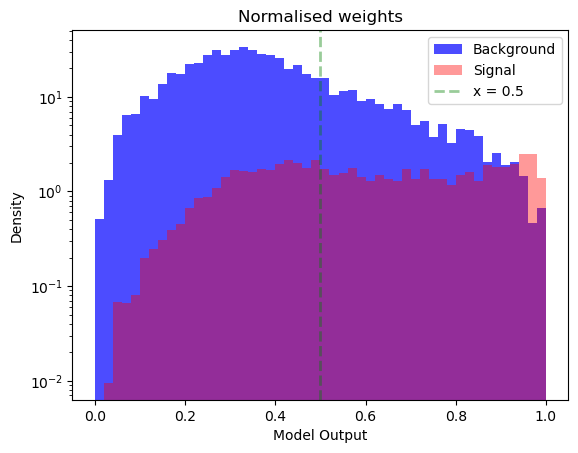

In [16]:
#reread


# Evaluate model on test set with normalised weights
model.eval()

# Lists to store model outputs and labels
all_outputs = []
all_labels = []

# Iterate over test data
with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # outputs = model(batch_x) applies the model to the input batch to generate model outputs.
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        #sigmoid function is applied to the model outputs to convert them to probabilities.
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility

        #all_outputs and all_labels are lists that store the model outputs and target labels for the test set.
        #.extend() appends the model outputs and target labels for each batch to the lists.
        all_outputs.extend(probs)

        #batch_y is the target labels for the batch. .numpy() converts the tensor to a numpy array.
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays

all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
all_labels = np.array(all_labels).flatten() # Flatten to a 1D array

plt.hist(all_outputs[all_labels == 0], bins=50, range=(0, 1),alpha = 0.7, label='Background', weights=wn_test[all_labels == 0]*200000, color='b')
plt.hist(all_outputs[all_labels == 1], bins=50, range=(0, 1), label='Signal',  weights=wn_test[all_labels == 1]*200000, color='r', alpha=0.4)
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='x = 0.5',alpha=0.4)
plt.xlabel('Model Output')
plt.yscale('log')

plt.ylabel('Density')
plt.title("Normalised weights")
plt.legend()
plt.show()



Instead of Z = S/sqrt(B),

Z = s/sqrt(B + sigma_b^2)  
where B is the background, S is the signal, and sigma_b is the uncertainty in the background.

Curve may peak in different place and curve will generally go down.

Maximum Z-score: 5.3088
Associated S value: 39.1373
Associated B value: 54.3452



Sigma = 0
Maximum Z score: 4.1530 at threshold = 0.8586
S = 13.9533, B = 11.2883

Sigma = 0.05
Maximum Z score: 4.0956 at threshold = 0.8586
S = 13.9533, B = 11.2883

Sigma = 0.1
Maximum Z score: 3.9598 at threshold = 0.9091
S = 9.3792, B = 5.3266


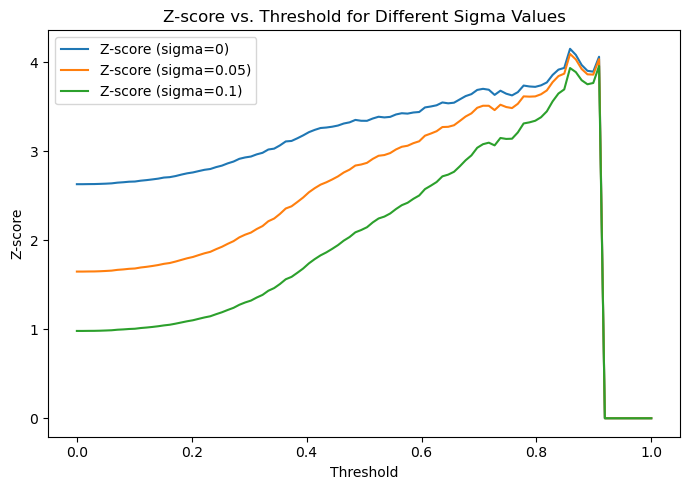

In [18]:
sigma_values = [0, 0.05, 0.1]

# Assume wn_test is the array of weights for each sample in the test set 
wn_test_array = np.array(wn_test * 200000)

# Define thresholds between 0 and 1
thresholds = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(7, 5))

for sigma in sigma_values:
    z_scores = []
    s_values = []
    b_values = []
    for threshold in thresholds:
        S = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 1)])  # Weighted Signal
        B = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 0)])  # Weighted Background
        s_values.append(S)
        b_values.append(B)
        
        # Checking both S and B are above a minimum value
        Z = S / np.sqrt(B + (sigma * B) ** 2 + 1e-10) if (S >= 5 and B >= 5) else 0
        z_scores.append(Z)
    
    ax.plot(thresholds, z_scores, label=f"Z-score (sigma={sigma})")
    
    # Find max Z score and corresponding threshold, S, B values
    max_Z = max(z_scores)
    max_index = z_scores.index(max_Z)
    best_threshold = thresholds[max_index]
    best_S = s_values[max_index]
    best_B = b_values[max_index]
    
    print(f"\nSigma = {sigma}")
    print(f"Maximum Z score: {max_Z:.4f} at threshold = {best_threshold:.4f}")
    print(f"S = {best_S:.4f}, B = {best_B:.4f}")

ax.set_xlabel("Threshold")
ax.set_ylabel("Z-score")
ax.set_title("Z-score vs. Threshold for Different Sigma Values")
ax.legend()

plt.tight_layout()
plt.show()

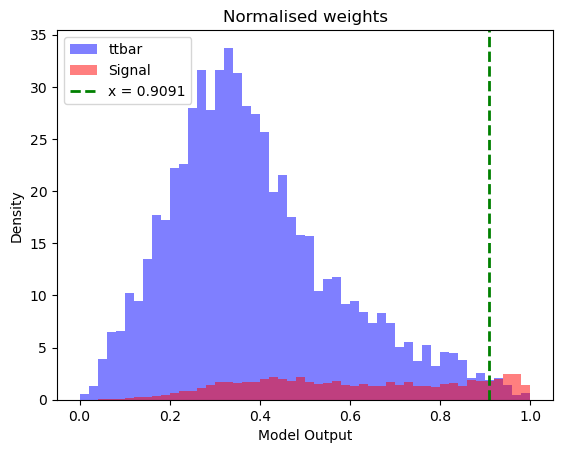

In [19]:
#reread


# Evaluate model on test set with normalised weights
model.eval()

# Lists to store model outputs and labels
all_outputs = []
all_labels = []

# Iterate over test data
with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # outputs = model(batch_x) applies the model to the input batch to generate model outputs.
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        #sigmoid function is applied to the model outputs to convert them to probabilities.
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility

        #all_outputs and all_labels are lists that store the model outputs and target labels for the test set.
        #.extend() appends the model outputs and target labels for each batch to the lists.
        all_outputs.extend(probs)

        #batch_y is the target labels for the batch. .numpy() converts the tensor to a numpy array.
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays

all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
all_labels = np.array(all_labels).flatten() # Flatten to a 1D array

plt.hist(all_outputs[all_labels == 0], 
         bins=50, 
         range=(0, 1),
         alpha = 0.5, 
         label='ttbar', 
         weights=wn_test[all_labels == 0]*200000, 
         color='b',)

plt.hist(all_outputs[all_labels == 1], 
         bins=50, 
         range=(0, 1), 
         label='Signal',  
         weights=wn_test[all_labels == 1]*200000, 
         color='r', 
         alpha=0.5)


plt.axvline(x=best_threshold, color='green', linestyle='--', linewidth=2, label='x = 'f"{best_threshold:.4f}")
plt.xlabel('Model Output')
plt.ylabel('Density')
plt.title("Normalised weights")
plt.legend()
plt.show()

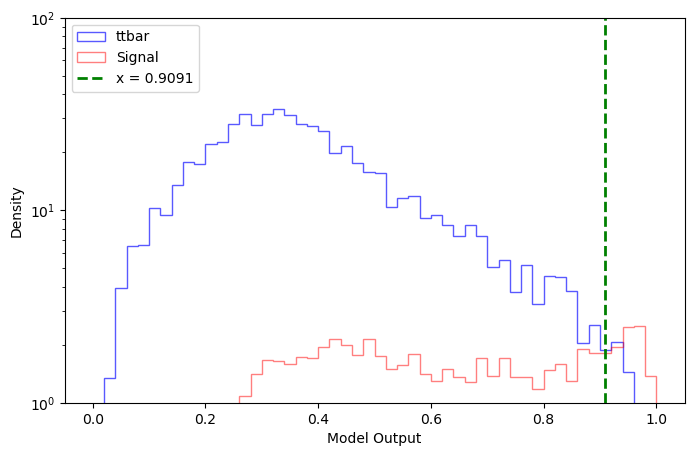

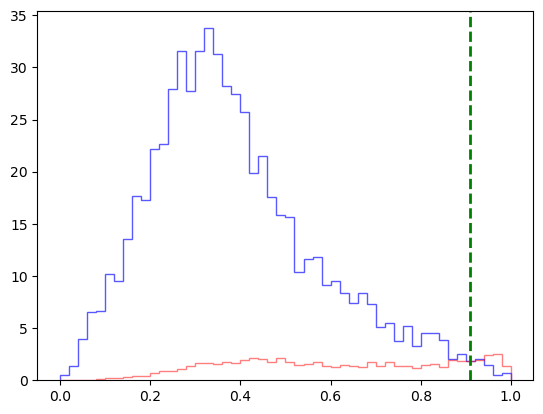

In [20]:
#reread


# Evaluate model on test set with normalised weights
model.eval()

# Lists to store model outputs and labels
all_outputs = []
all_labels = []

# Iterate over test data
with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # outputs = model(batch_x) applies the model to the input batch to generate model outputs.
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        #sigmoid function is applied to the model outputs to convert them to probabilities.
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility

        #all_outputs and all_labels are lists that store the model outputs and target labels for the test set.
        #.extend() appends the model outputs and target labels for each batch to the lists.
        all_outputs.extend(probs)

        #batch_y is the target labels for the batch. .numpy() converts the tensor to a numpy array.
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays

all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
all_labels = np.array(all_labels).flatten() # Flatten to a 1D array

plt.figure(figsize = (8,5))
plt.hist(all_outputs[all_labels == 0], 
         bins=50, 
         range=(0, 1),
         alpha = 0.65, 
         label='ttbar', 
         weights=wn_test[all_labels == 0]*200000, 
         color='b',
         log=True,
         histtype='step')

plt.hist(all_outputs[all_labels == 1], 
         bins=50, 
         range=(0, 1), 
         label='Signal',  
         weights=wn_test[all_labels == 1]*200000, 
         color='r', 
         alpha=0.5,
         log=True,
         histtype='step')
plt.ylim(1,100)


plt.axvline(x=best_threshold, color='green', linestyle='--', linewidth=2, label='x = 'f"{best_threshold:.4f}")
plt.xlabel('Model Output')
plt.ylabel('Density')

#plt.title("Normalised weights")
plt.legend(loc='upper left')
plt.show()


plt.hist(all_outputs[all_labels == 0], 
         bins=50, 
         range=(0, 1),
         alpha = 0.65, 
         label='ttbar', 
         weights=wn_test[all_labels == 0]*200000, 
         color='b',
         log=False,
         histtype='step')
plt.hist(all_outputs[all_labels == 1], 
         bins=50, 
         range=(0, 1), 
         label='Signal',  
         weights=wn_test[all_labels == 1]*200000, 
         color='r', 
         alpha=0.5,
         log=False,
         histtype='step')

#plt.ylim(0.01,50)
plt.axvline(x=best_threshold, color='green', linestyle='--', linewidth=2, label='x = 'f"{best_threshold:.4f}")
plt.show()

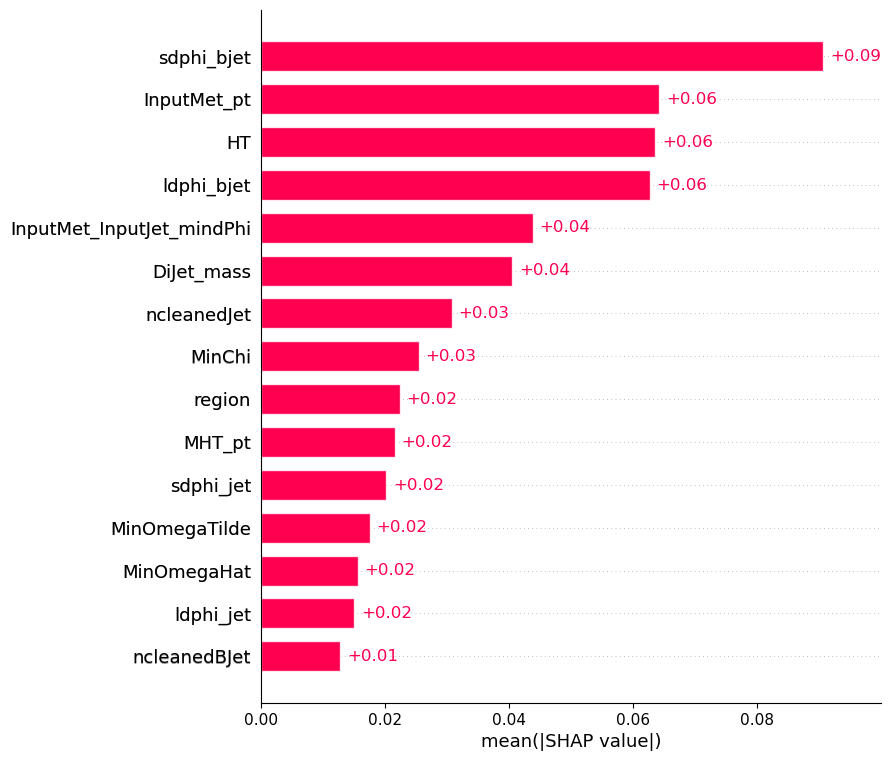

<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_558378/2780345200.py:33: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test_np[:100], feature_names=features, max_display=len(features))


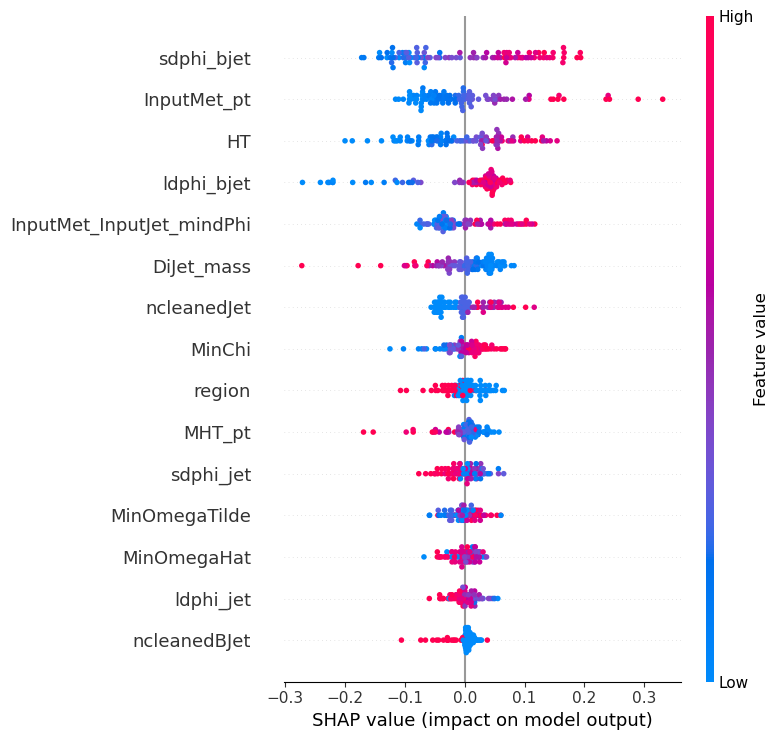

<Figure size 640x480 with 0 Axes>

In [21]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt

def model_forward(batch_np):
    batch_torch = torch.from_numpy(batch_np).float().to(device)
    with torch.no_grad():
        out = model(batch_torch)
        probs = torch.sigmoid(out).cpu().numpy()
    return probs

X_test_np = X_test.numpy()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create explainer
explainer = shap.Explainer(model_forward, X_test_np[:100])  # Use sample of data as background

# Compute SHAP values
shap_values = explainer(X_test_np[:100])  # Use fewer samples for speed

# Set feature names
shap_values.feature_names = features

# Plot all features individually - set max_display to show ALL features
plt.figure(figsize=(10, 8))
shap.plots.bar(shap_values, max_display=len(features))  # Show all features
plt.tight_layout()
plt.show()

# For beeswarm plot, also show all features
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values.values, X_test_np[:100], feature_names=features, max_display=len(features))
plt.tight_layout()
plt.show()

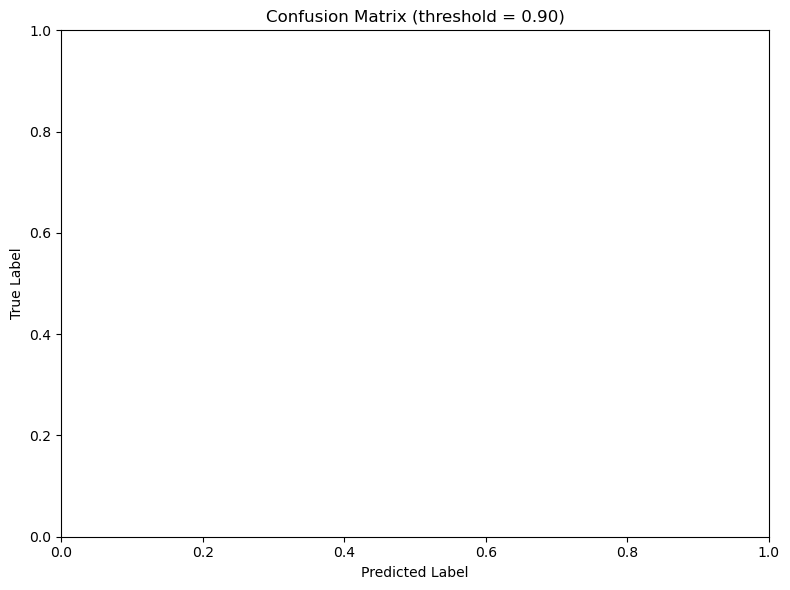

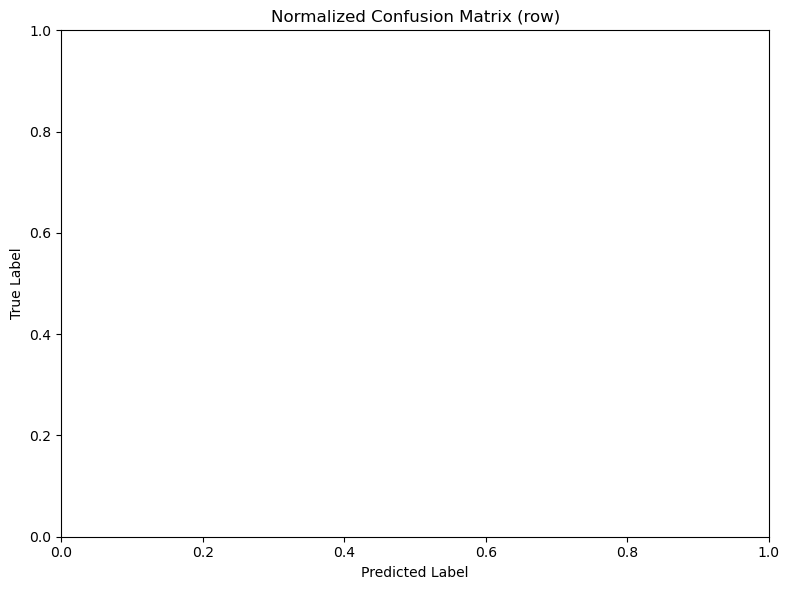

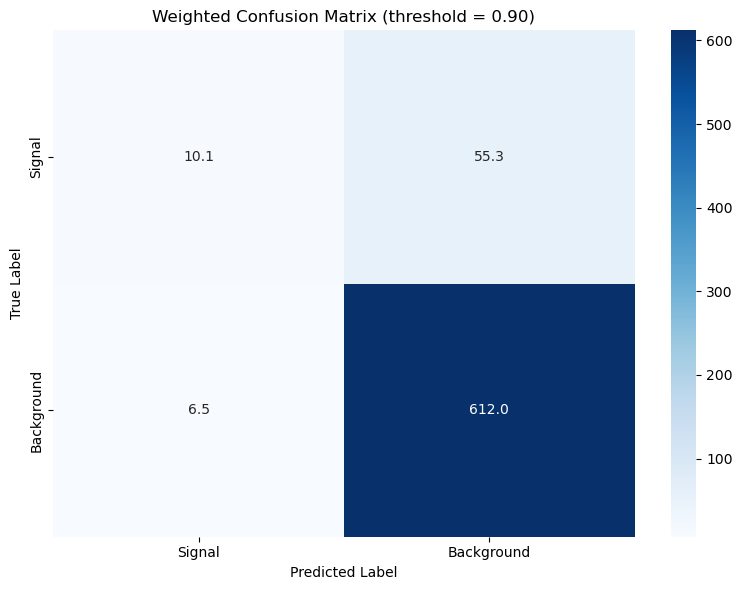

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Convert the output probabilities to binary predictions using the optimal threshold
y_pred_binary = (np.array(all_outputs) > best_threshold).astype(int)
y_true = all_labels

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_binary)

# Reorder the matrix to put Signal first, Background second
conf_matrix = conf_matrix[[1,0],:][:,[1,0]]  # Swap rows and columns

# Calculate performance metrics (using the original matrix)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Plot 1: Standard confusion matrix
plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['Signal', 'Background'],  # Swapped order
#             yticklabels=['Signal', 'Background'])  # Swapped order
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (threshold = {:.2f})'.format(best_threshold))
plt.tight_layout()
plt.show()

# Plot 2: Normalized confusion matrix
plt.figure(figsize=(8, 6))
# Normalize the reordered matrix
conf_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
# sns.heatmap(conf_norm, annot=True, fmt='.2f', cmap='Blues',
#             xticklabels=['Signal', 'Background'],  # Swapped order
#             yticklabels=['Signal', 'Background'])  # Swapped order
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (row)')
plt.tight_layout()
plt.show()

# Plot 3: Weighted confusion matrix
plt.figure(figsize=(8, 6))
weighted_conf_matrix = np.zeros((2, 2))
wn_test_array = np.array(wn_test) * 200000

# Calculate weighted matrix with swapped indices
for i in range(2):
    for j in range(2):
        # Use (1-i) and (1-j) to swap 0->1 and 1->0
        mask = (y_true == (1-i)) & (y_pred_binary == (1-j))
        weighted_conf_matrix[i, j] = np.sum(wn_test_array[mask])

sns.heatmap(weighted_conf_matrix, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['Signal', 'Background'],  # Swapped order
            yticklabels=['Signal', 'Background'])  # Swapped order
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Weighted Confusion Matrix (threshold = {:.2f})'.format(best_threshold))
plt.tight_layout()
plt.show()

#### Pretty Confusion Matrix For Report:

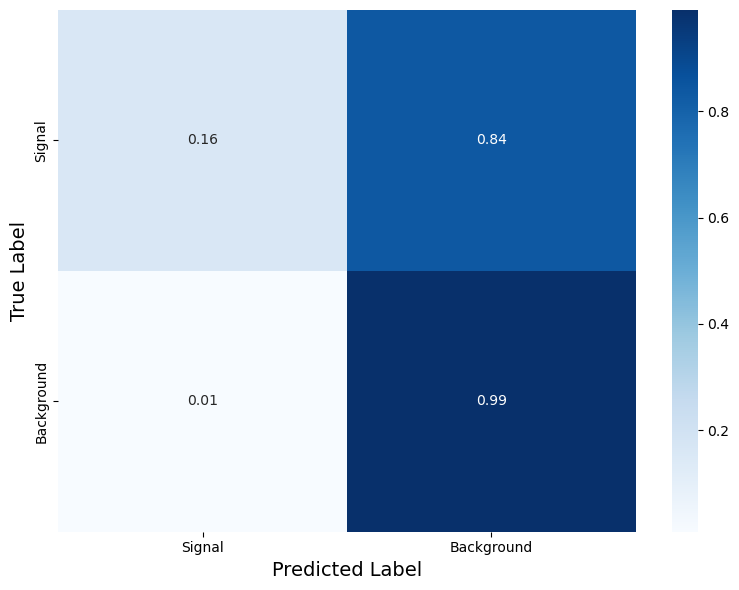

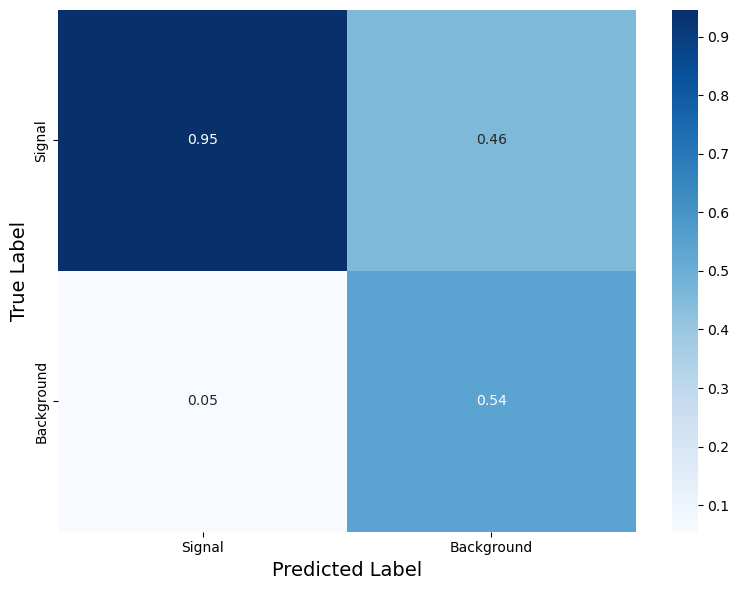

Metrics (threshold = 0.90):
Accuracy: 0.5782
Precision: 0.9453
Recall (Sensitivity): 0.1591
F1 Score: 0.2724
Specificity: 0.9909


In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Use the best threshold
best_threshold = 0.90

# Convert the output probabilities to binary predictions
y_pred_binary = (np.array(all_outputs) > best_threshold).astype(int)
y_true = all_labels

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_binary)

# Reorder the matrix to put Signal first, Background second
conf_matrix = conf_matrix[[1,0],:][:,[1,0]]  # Swap rows and columns

# Calculate performance metrics (using the original matrix)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Plot 1: Normalized by row (shows classification rate)
plt.figure(figsize=(8, 6))
conf_norm_row = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_norm_row, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Signal', 'Background'],
            yticklabels=['Signal', 'Background'])
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

# Plot 2: Normalized by column (shows precision)
plt.figure(figsize=(8, 6))
conf_norm_col = conf_matrix.astype('float') / conf_matrix.sum(axis=0)[np.newaxis, :]
sns.heatmap(conf_norm_col, annot=True, fmt='.2f', s',
            xticklabels=['Signal', 'Background'],
            yticklabels=['Signal', 'Background'])
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

# Print metrics
print(f"Metrics (threshold = {best_threshold:.2f}):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {tn/(tn+fp):.4f}")